# Beijing Air Quality Forecasting Starter Notebook

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# cell2
# Load the datasets
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test .csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [ ]:
# cell 3
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [ ]:
# cell 4
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [ ]:
#cell 5
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [ ]:
# cell 6
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [28]:
# cell 7


# Drop target and unnecessary columns
features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']
X_train = train[features].values
y_train = train['pm2.5'].values
X_test = test[features].values

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to create sequences
def create_sequences(X, y=None, time_steps=6):
    """
    Create sequences for LSTM.
    X: features (scaled)
    y: target (optional, for train)
    time_steps: number of previous hours to include
    """
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])
        if y is not None:
            ys.append(y[i])
    Xs = np.array(Xs)
    if y is not None:
        ys = np.array(ys)
        return Xs, ys
    return Xs

# Create sequences with 6 timesteps (last 6 hours)
TIME_STEPS = 6
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, TIME_STEPS)
X_test_seq = create_sequences(X_test_scaled, time_steps=TIME_STEPS)

print("X_train_seq shape:", X_train_seq.shape)  # (samples, timesteps, features)
print("X_test_seq shape:", X_test_seq.shape)


X_train_seq shape: (30670, 6, 9)
X_test_seq shape: (13142, 6, 9)


In [ ]:
# cell 8
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
# X_train = np.expand_dims(X_train, axis=1)

# Reshape for LSTM: (samples, timesteps=1, features)
# X_train_scaled = np.expand_dims(X_train_scaled, axis=1)
# X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

# # Check shapes
# print("X_train_scaled shape:", X_train_scaled.shape)
# print("X_test_scaled shape:", X_test_scaled.shape) 

X_train_scaled shape: (30676, 1, 9)
X_test_scaled shape: (13148, 1, 9)


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [30]:
# cell 9

# Train the model (example: 32 units, 1 layer)
model = Sequential([
    LSTM(32, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)
# Display model summary
model.summary()



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# cell 10
# Train the model
# Train the model with scaled features
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32)


Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - lambda: 123.3829 - loss: 15786.1816
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 104.0387 - loss: 11367.0615
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 93.4833 - loss: 9187.8818
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - lambda: 88.9497 - loss: 8370.1230
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - lambda: 91.0010 - loss: 7811.3291
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 96.5494 - loss: 6744.4019
Epoch 7/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - lambda: 96.6738 - loss: 5999.0464
Epoch 8/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - lambda: 97.2460 - loss: 5788.5474
Epoch 9/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - lambda: 98.4060 - loss: 5656.4492
Epoch 10/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - lambda: 98.5531 - loss: 5441.0493
Epoch 11/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - lambda: 99.3933 - loss: 5347.4829
Epoch 12/50
959/959 

959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


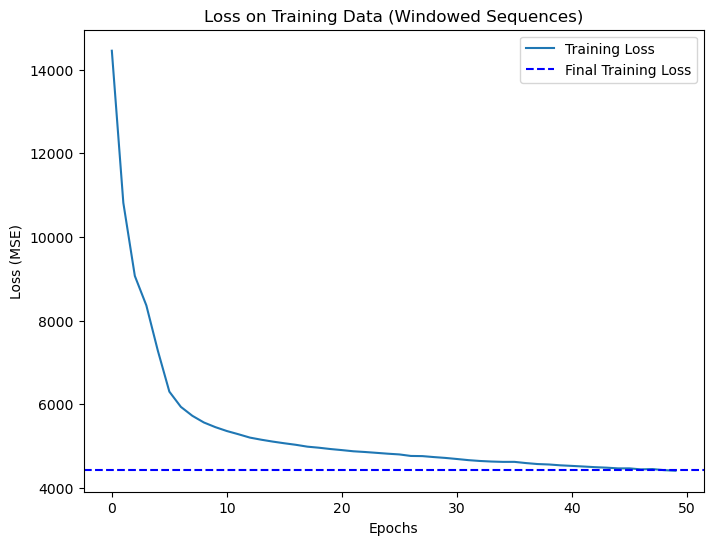

Final Training Loss (MSE): 4421.40


In [32]:
# cell 11
# Calculate training loss
# Calculate training loss (MSE)
# Calculate training loss on sequences
train_predictions = model.predict(X_train_seq)
train_loss = np.mean((y_train_seq - train_predictions.flatten())**2)

# Plot training loss over epochs
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')  # MSE during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Training Loss')  # Final MSE
plt.title('Loss on Training Data (Windowed Sequences)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss:.2f}")



In [38]:
# Predict on test sequences
predictions = model.predict(X_test_seq)
predictions = np.nan_to_num(predictions)  # handle NaNs

# Pad the first TIME_STEPS rows
pad_rows = TIME_STEPS
first_pred = predictions[0].flatten()
predictions_full = np.vstack([np.repeat(first_pred.reshape(1,1), pad_rows, axis=0), predictions])

# Load sample_submission to get exact row IDs
sample_sub = pd.read_csv('Data/sample_submission .csv')

# Prepare submission using exact row IDs
submission = pd.DataFrame({
    'row ID': sample_sub['row ID'],
    'pm2.5': predictions_full.flatten()
})

# Save submission CSV
submission.to_csv('submissions/submission_baseline.csv', index=False)
print("Submission saved: submissions/submission_baseline.csv")


411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Submission saved: submissions/submission_baseline.csv
